In [1]:
!pip install -U accelerate bitsandbytes transformers huggingface_hub > /dev/null 2>&1
!pip install torch --upgrade > /dev/null 2>&1

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
import pandas as pd
import os

In [56]:
# Import necessary classes for model loading and quantization
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import transformers
import torch
# Configure model quantization to 4-bit for memory and computation efficiency
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

# Load the tokenizer for the Gemma 7B Italian model
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")

# Load the Gemma 7B Italian model itself, with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained("google/gemma-7b-it",
                                             device_map="cuda",
                                             torch_dtype=torch.bfloat16,
                                             quantization_config=quantization_config)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
import re
import json
def classify_text(text, model,tokenizer, max_new_tokens=50):
    input_text = f"Classify the following text into one of the following SDoH categories ('Employment', 'Housing', 'Transportation', 'Parental Status', 'Relationship', 'Social Support') and identify if it is 'Adverse' or 'Non-Adverse':\n\nText: \"{text}\"?\n give your response in a json with the keys 'category' and 'adverse label'"
    chat = [
    { "role": "user", "content": input_text },
    ]
    prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=50)
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract JSON from the output using regex
    json_str_match = re.search(r'```json\n(\{.*?\})\n```', output_text, re.DOTALL)
    if json_str_match:
        json_str = json_str_match.group(1)
        try:
            data = json.loads(json_str)
            # Normalize keys to lowercase
            normalized_data = {k.lower(): v for k, v in data.items()}
            return normalized_data
        except json.JSONDecodeError as e:
            print(f"JSON decoding failed: {e}\n\nFull output: {output_text}")
            return {"category": "Error", "adverse label": "Error"}
    else:
        print(f"No JSON found. Full output: {output_text}")
        return {"category": "None found", "adverse label": "None found"}
    # a=tokenizer.decode(outputs[0])
    # print(a)
    # return a


In [58]:
# result = classify_text("Pt expresses concern about eviction notice received from landlord.", model,tokenizer)
# print("Category:", result.get('category', 'None found'))
# print("Adverse Label:", result.get('adverse label', 'None found'))

In [59]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/Iteration__1.csv')
train_df, data = train_test_split(data, test_size=0.2, random_state=42)
# Initialize columns for the predictions
data['predicted_label'] = ''
data['predicted_adverse'] = ''

In [60]:
def normalize_keys(data_dict):
    return {k.lower(): v for k, v in data_dict.items()}

def adjust_labels(label):
    label = label.upper()
    if label == "PARENTAL STATUS":
        return "PARENT"
    if label == "SOCIAL SUPPORT":
        return "SUPPORT"
    if label not in ["EMPLOYMENT", "HOUSING", "TRANSPORTATION", "PARENT", "SUPPORT", "RELATIONSHIP"]:
        return "NONE"
    return label

def adjust_adverse(adverse):
    adverse = adverse.lower().replace("non-adverse", "nonadverse").replace("non adverse", "nonadverse")
    return adverse

In [61]:
# counter =0
for index, row in data.iterrows():
    # counter =counter +1
    # if counter == 5:
    #   break
    prediction = classify_text(row['text'],model,tokenizer)
    # prediction_dict = prediction.choices[0].message.content
    # prediction_dict = eval(prediction_dict)
    # # print(prediction_dict)
    # normalized_prediction = normalize_keys(prediction_dict)  # Converting string representation of dictionary back to
    if type(prediction) == str:
      print(prediction)
    else:
      label = prediction.get('category', 'None found')
      adverse = prediction.get('adverse label', 'None found')
      if label == 'None found' or adverse == 'None found':
          print(prediction)
    # normalized_prediction = normalize_keys(prediction)  # Converting string representation of dictionary back to
      adjusted_label = adjust_labels(label)
      adjusted_adverse = adjust_adverse(adverse)

      data.at[index, 'predicted_label'] = adjusted_label
      data.at[index, 'predicted_adverse'] = adjusted_adverse



In [62]:
# for i in range(5):
#   print(data.iloc[i]['text'])
#   print(data.iloc[i]['predicted_label'])
#   print(data.iloc[i]['predicted_adverse'])

In [64]:
data = data[data['predicted_adverse'].isin(['adverse', 'nonadverse'])]
data.to_csv('/content/sdoh_test_output.csv', index=False)


In [65]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [66]:
data = pd.read_csv('/content/sdoh_test_output.csv')

In [67]:
# Calculate accuracies
sdoh_accuracy = accuracy_score(data['label'], data['predicted_label'])
adverse_accuracy = accuracy_score(data['adverse'], data['predicted_adverse'])
print("Accuracy on SDoH dataset test set ")
print(f"SDOH Label Accuracy: {sdoh_accuracy * 100:.2f}%")
print(f"Adverse Label Accuracy: {adverse_accuracy * 100:.2f}%")

Accuracy on SDoH dataset test set 
SDOH Label Accuracy: 68.33%
Adverse Label Accuracy: 71.11%


In [68]:
# Calculate confusion matrices
sdoh_cm = confusion_matrix(data['label'], data['predicted_label'])
adverse_cm = confusion_matrix(data['adverse'], data['predicted_adverse'])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

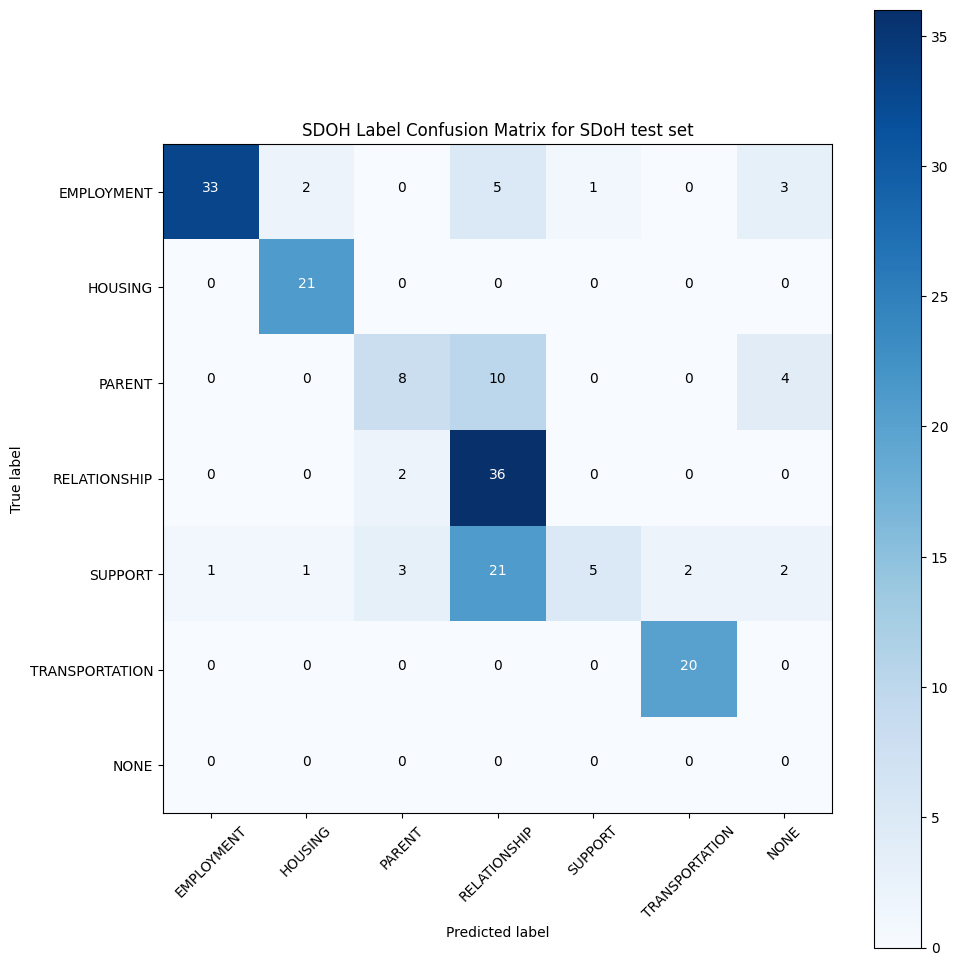

In [69]:
# Plotting confusion matrices
# For SDOH_LABEL
unique_sdoh_labels = sorted(data['label'].unique())
unique_sdoh_labels.append('NONE')
sdoh_cm = confusion_matrix(data['label'], data['predicted_label'], labels=unique_sdoh_labels)
plot_confusion_matrix(sdoh_cm, classes=unique_sdoh_labels, title='SDOH Label Confusion Matrix for SDoH test set')
plt.show()

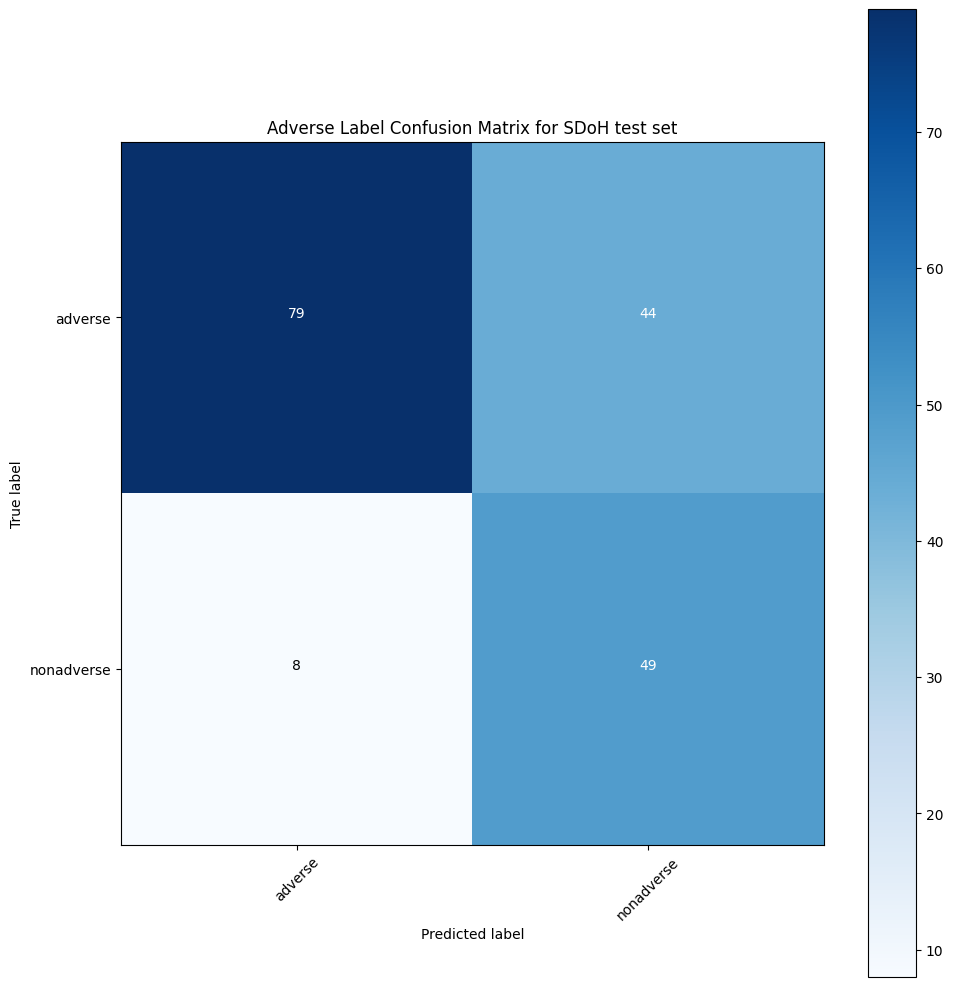

In [70]:
# For ADVERSE_LABEL
unique_adverse_labels = sorted(data['adverse'].unique())
adverse_cm = confusion_matrix(data['adverse'], data['predicted_adverse'],labels = unique_adverse_labels)

plot_confusion_matrix(adverse_cm, classes=unique_adverse_labels, title='Adverse Label Confusion Matrix for SDoH test set')
plt.show()

#Testing on augmented MTS Dataset

In [71]:
data = pd.read_csv('/content/augmented_mts.csv')
# Initialize columns for the predictions
data['predicted_label'] = ''
data['predicted_adverse'] = ''

In [72]:
# counter =0
for index, row in data.iterrows():
    # counter =counter +1
    # if counter == 5:
    #   break
    prediction = classify_text(row['section_text'],model,tokenizer)
    # prediction_dict = prediction.choices[0].message.content
    # prediction_dict = eval(prediction_dict)
    # # print(prediction_dict)
    # normalized_prediction = normalize_keys(prediction_dict)  # Converting string representation of dictionary back to
    if type(prediction) == str:
      print(prediction)
    else:
      label = prediction.get('category', 'None found')
      adverse = prediction.get('adverse label', 'None found')
      if label == 'None found' or adverse == 'None found':
          print(prediction)
    # normalized_prediction = normalize_keys(prediction)  # Converting string representation of dictionary back to
      adjusted_label = adjust_labels(label)
      adjusted_adverse = adjust_adverse(adverse)

      data.at[index, 'predicted_label'] = adjusted_label
      data.at[index, 'predicted_adverse'] = adjusted_adverse

{'category': 'Relationship', 'adverse_label': 'Non-Adverse'}


In [73]:
# for i in range(5):
#   print(data.iloc[i]['section_text'])
#   print(data.iloc[i]['predicted_label'])
#   print(data.iloc[i]['predicted_adverse'])

In [74]:
data['Adverse Category'] = data['Adverse Category'].str.replace('non-adverse', 'nonadverse', regex=False)
data = data[data['predicted_adverse'].isin(['adverse', 'nonadverse'])]
data.to_csv('/content/mts_output.csv', index=False)


In [75]:
data = pd.read_csv('/content/mts_output.csv')

In [76]:
# Calculate accuracies
sdoh_accuracy = accuracy_score(data['SDOH label'], data['predicted_label'])
adverse_accuracy = accuracy_score(data['Adverse Category'], data['predicted_adverse'])
print("Accuracy on augmented MTS dataset")
print(f"SDOH Label Accuracy: {sdoh_accuracy * 100:.2f}%")
print(f"Adverse Label Accuracy: {adverse_accuracy * 100:.2f}%")

Accuracy on augmented MTS dataset
SDOH Label Accuracy: 57.58%
Adverse Label Accuracy: 53.54%


In [77]:
# Calculate confusion matrices
# sdoh_cm = confusion_matrix(data['label'], data['predicted_label'])
# adverse_cm = confusion_matrix(data['adverse'], data['predicted_adverse'])

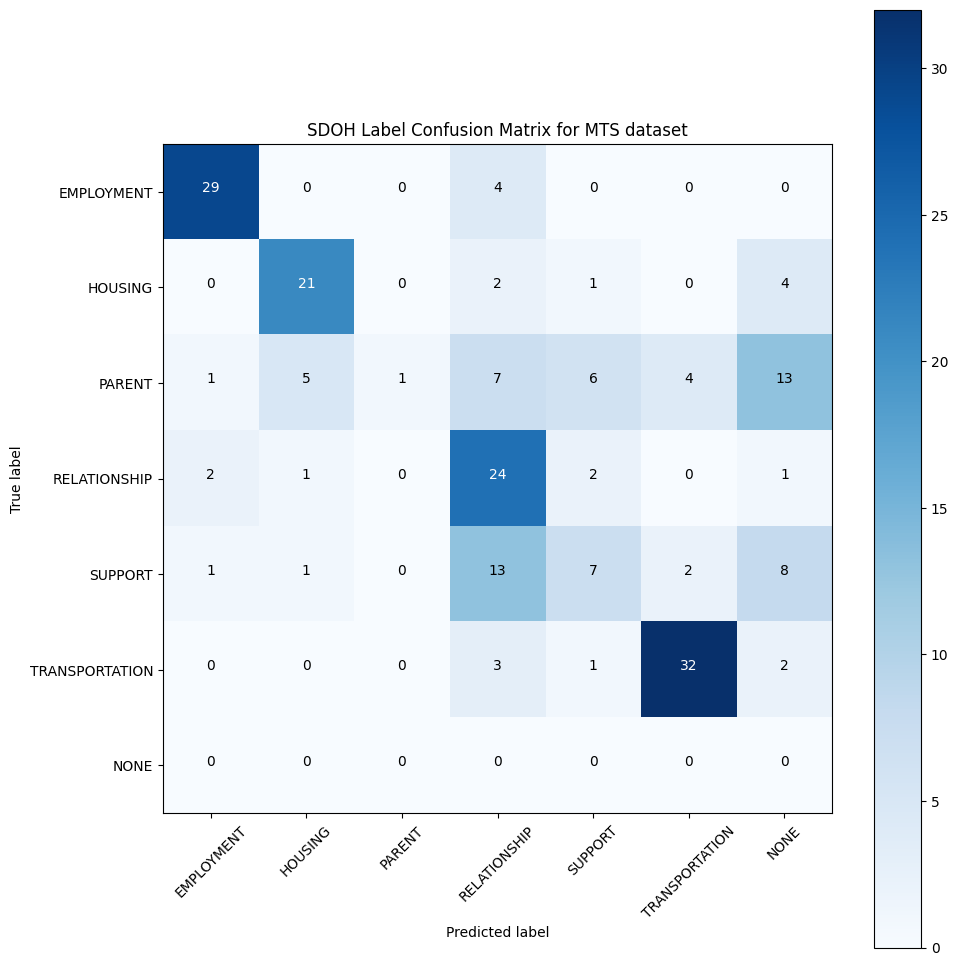

In [79]:
# Plotting confusion matrices
# For SDOH_LABEL
unique_sdoh_labels = sorted(data['SDOH label'].unique())
unique_sdoh_labels.append('NONE')
sdoh_cm = confusion_matrix(data['SDOH label'], data['predicted_label'], labels=unique_sdoh_labels)
plot_confusion_matrix(sdoh_cm, classes=unique_sdoh_labels, title='SDOH Label Confusion Matrix for MTS dataset')
plt.show()

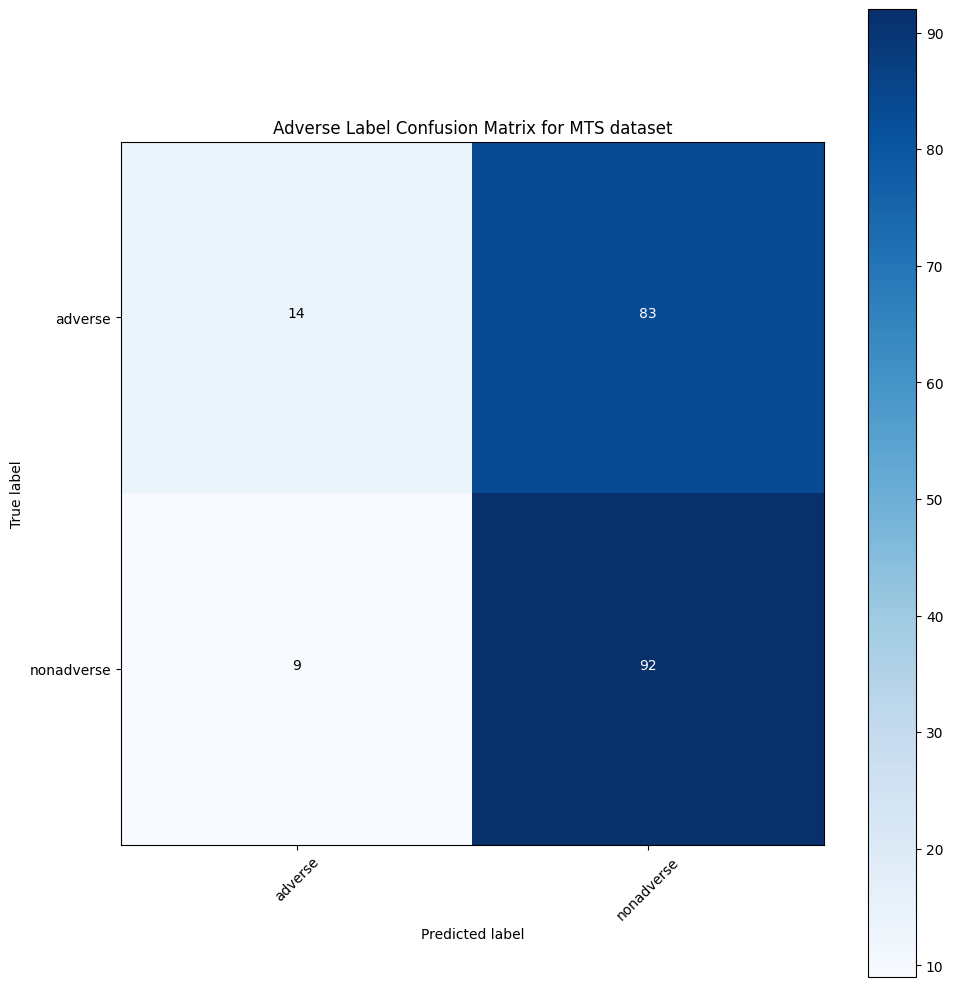

In [80]:
# For ADVERSE_LABEL
# For ADVERSE_LABEL
unique_adverse_labels = sorted(data['Adverse Category'].unique())
adverse_cm = confusion_matrix(data['Adverse Category'], data['predicted_adverse'],labels = unique_adverse_labels)

plot_confusion_matrix(adverse_cm, classes=unique_adverse_labels, title='Adverse Label Confusion Matrix for MTS dataset')
plt.show()